<a href="https://colab.research.google.com/github/bnsreenu/python_for_microscopists/blob/master/331_fine_tune_SAM_mito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install dependence

## SAM+Transformers

In [6]:
# Install the required libraries
#SAM
!pip install git+https://github.com/facebookresearch/segment-anything.git
#Transformers
!pip install -q git+https://github.com/huggingface/transformers.git
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-4n4sqzb2
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-4n4sqzb2
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Created wheel for segment_anything: filename=segment_anything-1.0-py3-none-any.whl size=36590 sha256=d2f2b1892b0a20b8d3e140d7420a1429adf0c8b23d849dc8a6e463f84874d4ef
  Stored in directory: /tmp/pip-ephem-wheel-cache-ajpr0yms/wheels/29/82/ff/04e2be9805a1cb48bec0b85b5a6da6b63f647645750a0e42d4
Successfully built segment_anything


In [3]:
import numpy as np
import matplotlib.pyplot as plt
# import tifffile
import os
# from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

# read image
from PIL import Image
# read labels
import pandas as pd


## load selfmade wooden images(COCO)

In [8]:
import numpy as np
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
from segment_anything import SamPredictor, sam_model_registry
import torchvision.transforms.functional as F

# Load the COCO dataset
coco_dataset = CocoDetection(
    root="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train",
    annFile="/mnt/data/backup_pan/Dataset/Seg-dominik-iphone/Dominik-seg.v4i.coco-segmentation/train/_annotations.coco.json",
    transform = ToTensor()
)

# Load the data into a DataLoader
dataloader = DataLoader(coco_dataset, batch_size=1, shuffle=False)


loading annotations into memory...
Done (t=0.09s)
creating index...
index created!


Image shape: torch.Size([3, 1024, 1024])
Number of targets: 1
Annotations: [{'id': tensor([0]), 'image_id': tensor([0]), 'category_id': tensor([1]), 'bbox': [tensor([259]), tensor([0]), tensor([461.3330], dtype=torch.float64), tensor([1024])], 'area': tensor([472405.3330], dtype=torch.float64), 'segmentation': [[tensor([270.6670], dtype=torch.float64), tensor([0]), tensor([269.3330], dtype=torch.float64), tensor([1]), tensor([269.3330], dtype=torch.float64), tensor([7]), tensor([266.6670], dtype=torch.float64), tensor([9]), tensor([266.6670], dtype=torch.float64), tensor([83]), tensor([269.3330], dtype=torch.float64), tensor([85]), tensor([269.3330], dtype=torch.float64), tensor([95]), tensor([266.6670], dtype=torch.float64), tensor([97]), tensor([266.6670], dtype=torch.float64), tensor([99]), tensor([269.3330], dtype=torch.float64), tensor([101]), tensor([269.3330], dtype=torch.float64), tensor([207]), tensor([266.6670], dtype=torch.float64), tensor([209]), tensor([266.6670], dtype=to

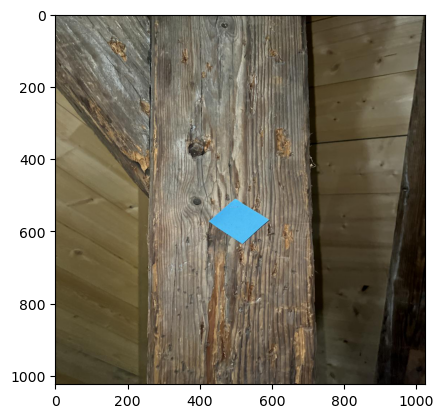

In [9]:
# Process the images
for images, targets in dataloader:
    # Since batch_size=1, we need to access images[0] and targets[0]
    image = images[0]
    target = targets[0]

    print(f"Image shape: {image.shape}")
    print(f"Number of targets: {len(targets)}")
    print(f"Annotations: {targets}")

    # Display the image
    plt.imshow(np.transpose(image.numpy(), (1, 2, 0)))
    plt.show()

    break  # Only display the first item


In [1]:
# Initialize the SAM model
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)

for images, targets in dataloader:
    image = images[0]
    image = F.to_pil_image(image)  # Convert to PIL Image
    image = np.array(image)  # Convert back to numpy array
    print(f"Image ID: {targets[0]['image_id']}")
    
    
    for target in targets:
        bboxes = target['bbox']
        num_boxes = len(bboxes) // 4
        bboxes = [float(val) for val in bboxes]
        
        # Split bbox into separate arrays for each box
        bboxes = np.array(bboxes).reshape(num_boxes, 4)
        print(f"Number of bounding boxes: {num_boxes}")
        # Process each bbox individually
        for bbox in bboxes:
            x_min, y_min, width, height = bbox
            x_max = x_min + width
            y_max = y_min + height
            input_bbox = np.array([x_min, y_min, x_max, y_max])
            print(f"Bounding box: {input_bbox}")
            
            predictor.set_image(image)
            masks, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

            # `masks` now contains the segmentation mask for the current bbox
            # You can now use `masks` for further processing or training


NameError: name 'sam_model_registry' is not defined

In [ ]:
import torch.optim as optim

# Assume we have a target loss function for SAM
def loss_function(pred_mask, true_mask):
    return torch.nn.functional.binary_cross_entropy(pred_mask, true_mask)

optimizer = optim.Adam(sam.parameters(), lr=0.001)

for epoch in range(num_epochs):
    for images, targets in dataloader:
        image = images[0].numpy().transpose(1, 2, 0)
        true_mask = targets[0]['segmentation']  # Simplified, you need to preprocess the segmentation

        for target in targets:
            bbox = target['bbox']
            x_min, y_min, width, height = bbox
            input_bbox = [x_min, y_min, x_min + width, y_min + height]

            predictor.set_image(image)
            pred_mask, _, _ = predictor.predict(box=input_bbox, point_coords=None, point_labels=None, multimask_output=False)

            # Compute loss
            loss = loss_function(pred_mask, true_mask)

            # Backpropagation
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            print(f'EPOCH: {epoch}')
            print(f'Mean loss: {mean(loss)}')


In [ ]:
# Save the model's state dictionary to a file
torch.save(model.state_dict(), "/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_model_checkpoint.pth")

**Inference**

In [ ]:
from transformers import SamModel, SamConfig, SamProcessor
import torch

In [ ]:
# Load the model configuration
model_config = SamConfig.from_pretrained("facebook/sam-vit-base")
processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

# Create an instance of the model architecture with the loaded configuration
my_mito_model = SamModel(config=model_config)
#Update the model by loading the weights from saved file.
my_mito_model.load_state_dict(torch.load("/content/drive/MyDrive/ColabNotebooks/models/SAM/mito_full_data_10_epochs_model_checkpoint.pth"))

<All keys matched successfully>

In [ ]:
# set the device to cuda if available, otherwise use cpu
device = "cuda" if torch.cuda.is_available() else "cpu"
my_mito_model.to(device)

SamModel(
  (shared_image_embedding): SamPositionalEmbedding()
  (vision_encoder): SamVisionEncoder(
    (patch_embed): SamPatchEmbeddings(
      (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    )
    (layers): ModuleList(
      (0-11): 12 x SamVisionLayer(
        (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (attn): SamVisionAttention(
          (qkv): Linear(in_features=768, out_features=2304, bias=True)
          (proj): Linear(in_features=768, out_features=768, bias=True)
        )
        (layer_norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): SamMLPBlock(
          (lin1): Linear(in_features=768, out_features=3072, bias=True)
          (lin2): Linear(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
        )
      )
    )
    (neck): SamVisionNeck(
      (conv1): Conv2d(768, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (layer_norm1): SamLayerNorm()
     

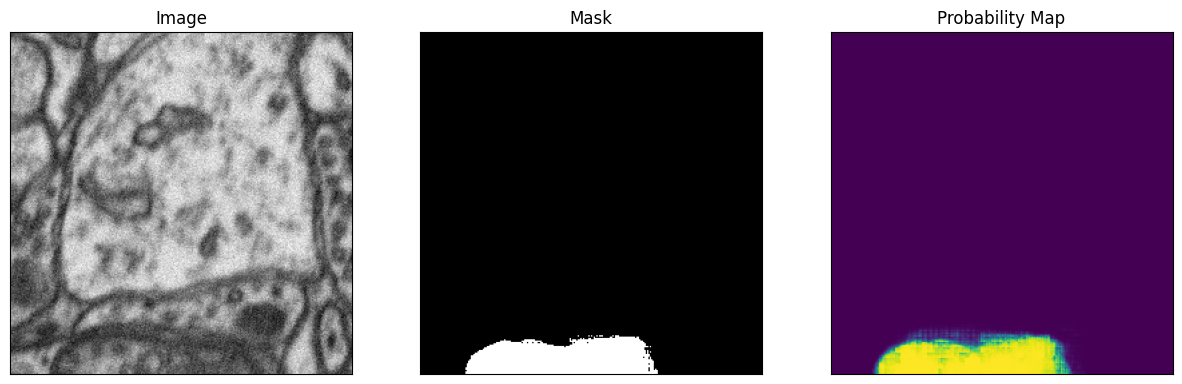

In [ ]:
import numpy as np
import random
import torch
import matplotlib.pyplot as plt

# let's take a random training example
idx = random.randint(0, filtered_images.shape[0]-1)

# load image
test_image = dataset[idx]["image"]

# get box prompt based on ground truth segmentation map
ground_truth_mask = np.array(dataset[idx]["label"])
prompt = get_bounding_box(ground_truth_mask)

# prepare image + box prompt for the model
inputs = processor(test_image, input_boxes=[[prompt]], return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}

my_mito_model.eval()

# forward pass
with torch.no_grad():
    outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
medsam_seg_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
medsam_seg_prob = medsam_seg_prob.cpu().numpy().squeeze()
medsam_seg = (medsam_seg_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(test_image), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(medsam_seg, cmap='gray')  # Assuming the second image is grayscale
axes[1].set_title("Mask")

# Plot the second image on the right
axes[2].imshow(medsam_seg_prob)  # Assuming the second image is grayscale
axes[2].set_title("Probability Map")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()


Now, let us load a new image and segment it using our trained model. NOte that we need to provide some prompt. Since we do not know where the objects are going to be we cannot supply bounding boxes. So let us provide a grid of points as our prompt.

In [ ]:
#Apply a trained model on large image
large_test_images = tifffile.imread("/content/drive/MyDrive/ColabNotebooks/data/mitochondria/small_dataset_for_training/images/12_training_mito_images.tif")
large_test_image = large_test_images[1]
patches = patchify(large_test_image, (256, 256), step=256)  #Step=256 for 256 patches means no overlap


In [ ]:
"""
input_points (torch.FloatTensor of shape (batch_size, num_points, 2)) —
Input 2D spatial points, this is used by the prompt encoder to encode the prompt.
Generally yields to much better results. The points can be obtained by passing a
list of list of list to the processor that will create corresponding torch tensors
of dimension 4. The first dimension is the image batch size, the second dimension
is the point batch size (i.e. how many segmentation masks do we want the model to
predict per input point), the third dimension is the number of points per segmentation
mask (it is possible to pass multiple points for a single mask), and the last dimension
is the x (vertical) and y (horizontal) coordinates of the point. If a different number
of points is passed either for each image, or for each mask, the processor will create
“PAD” points that will correspond to the (0, 0) coordinate, and the computation of the
embedding will be skipped for these points using the labels.

"""
# Define the size of your array
array_size = 256

# Define the size of your grid
grid_size = 10

# Generate the grid points
x = np.linspace(0, array_size-1, grid_size)
y = np.linspace(0, array_size-1, grid_size)

# Generate a grid of coordinates
xv, yv = np.meshgrid(x, y)

# Convert the numpy arrays to lists
xv_list = xv.tolist()
yv_list = yv.tolist()

# Combine the x and y coordinates into a list of list of lists
input_points = [[[int(x), int(y)] for x, y in zip(x_row, y_row)] for x_row, y_row in zip(xv_list, yv_list)]

#We need to reshape our nxn grid to the expected shape of the input_points tensor
# (batch_size, point_batch_size, num_points_per_image, 2),
# where the last dimension of 2 represents the x and y coordinates of each point.
#batch_size: The number of images you're processing at once.
#point_batch_size: The number of point sets you have for each image.
#num_points_per_image: The number of points in each set.
input_points = torch.tensor(input_points).view(1, 1, grid_size*grid_size, 2)

In [ ]:
print(np.array(input_points).shape)

(1, 1, 100, 2)


In [ ]:
patches.shape

(3, 4, 256, 256)

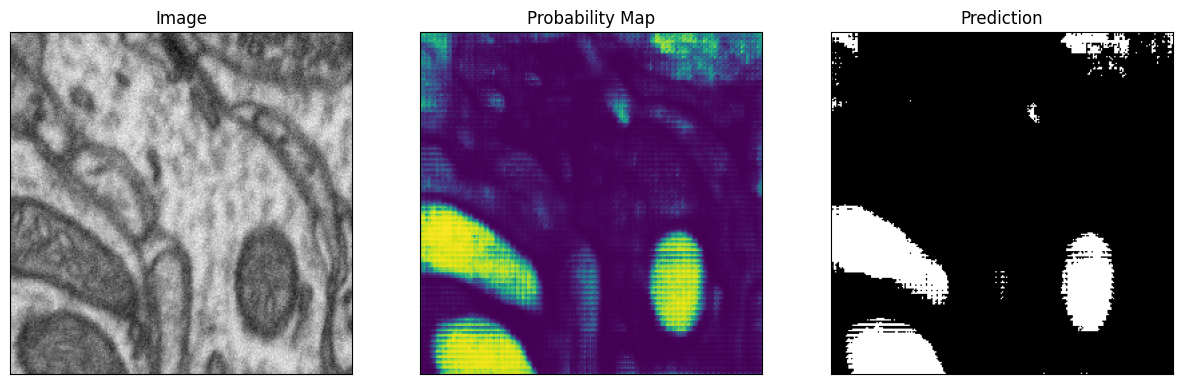

In [ ]:
# Select a random patch for segmentation

# Compute the total number of 256x256 arrays
#num_arrays = patches.shape[0] * patches.shape[1]
# Select a random index
#index = np.random.choice(num_arrays)
# Compute the indices in the original array
#i = index // patches.shape[1]
#j = index % patches.shape[1]

#Or pick a specific patch for study.
i, j = 1, 2

# Selectelected patch for segmentation
random_array = patches[i, j]


single_patch = Image.fromarray(random_array)
# prepare image for the model

#First try without providing any prompt (no bounding box or input_points)
#inputs = processor(single_patch, return_tensors="pt")
#Now try with bounding boxes. Remember to uncomment.
inputs = processor(single_patch, input_points=input_points, return_tensors="pt")

# Move the input tensor to the GPU if it's not already there
inputs = {k: v.to(device) for k, v in inputs.items()}
my_mito_model.eval()


# forward pass
with torch.no_grad():
  outputs = my_mito_model(**inputs, multimask_output=False)

# apply sigmoid
single_patch_prob = torch.sigmoid(outputs.pred_masks.squeeze(1))
# convert soft mask to hard mask
single_patch_prob = single_patch_prob.cpu().numpy().squeeze()
single_patch_prediction = (single_patch_prob > 0.5).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot the first image on the left
axes[0].imshow(np.array(single_patch), cmap='gray')  # Assuming the first image is grayscale
axes[0].set_title("Image")

# Plot the second image on the right
axes[1].imshow(single_patch_prob)  # Assuming the second image is grayscale
axes[1].set_title("Probability Map")

# Plot the second image on the right
axes[2].imshow(single_patch_prediction, cmap='gray')  # Assuming the second image is grayscale
axes[2].set_title("Prediction")

# Hide axis ticks and labels
for ax in axes:
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

# Display the images side by side
plt.show()